In [5]:
import os, numpy as np, torch, torchaudio, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt, seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

train_dir, test_dir = "cleaned_dataset/train", "cleaned_dataset/test"
class_names = ["others", "questions"]  # 0 / 1

Using device: cpu


In [9]:
SR, N_MELS, CLIP_SEC = 16000, 64, 3
MAX_LEN = SR * CLIP_SEC  # samples


class AudioDataset(Dataset):
    def __init__(self, paths, labels, augment=False):
        self.paths, self.labels, self.augment = paths, labels, augment
        self.mel = torchaudio.transforms.MelSpectrogram(
            sample_rate=SR, n_fft=1024, hop_length=512, n_mels=N_MELS
        )
        self.to_db = torchaudio.transforms.AmplitudeToDB(top_db=80)
        self.t_mask = torchaudio.transforms.TimeMasking(time_mask_param=30)
        self.f_mask = torchaudio.transforms.FrequencyMasking(freq_mask_param=8)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        wav, sr = torchaudio.load(self.paths[idx])

        # ── NEW: handle empty or corrupted files ─────────────────────────────
        if wav.numel() == 0 or wav.size(1) == 0:
            # replace with silence of full length
            wav = torch.zeros(1, MAX_LEN)
            sr = SR
        # ─────────────────────────────────────────────────────────────────────

        wav = wav.mean(0, keepdim=True)
        if sr != SR:
            wav = torchaudio.functional.resample(wav, sr, SR)

        # pad / truncate to fixed length
        wav = (
            nn.functional.pad(wav, (0, MAX_LEN - wav.size(1)))
            if wav.size(1) < MAX_LEN
            else wav[:, :MAX_LEN]
        )

        spec = self.to_db(self.mel(wav))
        if self.augment:
            spec = self.t_mask(self.f_mask(spec))
        spec = (spec - spec.min()) / (spec.max() - spec.min() + 1e-6)
        return spec, torch.tensor(self.labels[idx], dtype=torch.long)


# collect files + stratified split
files, labels = [], []
for cname in class_names:
    folder = os.path.join(train_dir, cname)
    files += [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".wav")]
    labels += [class_names.index(cname)] * len(os.listdir(folder))

tr_paths, val_paths, tr_lbls, val_lbls = train_test_split(
    files, labels, test_size=0.2, stratify=labels, random_state=42
)

test_files, test_lbls = [], []
for cname in class_names:
    folder = os.path.join(test_dir, cname)
    test_files += [
        os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".wav")
    ]
    test_lbls += [class_names.index(cname)] * len(os.listdir(folder))

train_ds = AudioDataset(tr_paths, tr_lbls, augment=True)
val_ds = AudioDataset(val_paths, val_lbls, augment=False)
test_ds = AudioDataset(test_files, test_lbls, augment=False)

batch_size = 32
train_loader = DataLoader(
    train_ds, batch_size, shuffle=True, num_workers=0, pin_memory=False
)
val_loader = DataLoader(
    val_ds, batch_size, shuffle=False, num_workers=0, pin_memory=False
)
test_loader = DataLoader(
    test_ds, batch_size, shuffle=False, num_workers=0, pin_memory=False
)

print(f"train {len(train_ds)}, val {len(val_ds)}, test {len(test_ds)}")

train 8218, val 2055, test 7145


In [10]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 1), nn.BatchNorm2d(16), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, 1, 1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, 1, 1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        x = self.block3(self.block2(self.block1(x)))
        x = F.adaptive_avg_pool2d(x, (1, 1)).view(x.size(0), -1)
        return self.fc(x)


model = CNNClassifier().to(device)
print(sum(p.numel() for p in model.parameters()) / 1e3, "K parameters")

23.585 K parameters


In [11]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", patience=3, factor=0.5
)

epochs, patience = 30, 5
best_loss, patience_ctr = float("inf"), 0
hist = {"tr_loss": [], "val_loss": [], "tr_acc": [], "val_acc": []}

for ep in range(1, epochs + 1):
    # ---- train ----
    model.train()
    tloss, tcorrect, tn = 0, 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        tloss += loss.item() * y.size(0)
        tcorrect += (torch.sigmoid(out).detach() >= 0.5).squeeze().eq(y).sum().item()
        tn += y.size(0)
    tr_loss, tr_acc = tloss / tn, tcorrect / tn

    # ---- validation ----
    model.eval()
    vloss, vcorrect, vn = 0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y.unsqueeze(1).float())
            vloss += loss.item() * y.size(0)
            vcorrect += (torch.sigmoid(out) >= 0.5).squeeze().eq(y).sum().item()
            vn += y.size(0)
    val_loss, val_acc = vloss / vn, vcorrect / vn
    scheduler.step(val_loss)

    hist["tr_loss"].append(tr_loss)
    hist["val_loss"].append(val_loss)
    hist["tr_acc"].append(tr_acc)
    hist["val_acc"].append(val_acc)

    print(
        f"Epoch {ep:02d} | tr_loss {tr_loss:.3f} acc {tr_acc:.3f} | "
        f"val_loss {val_loss:.3f} acc {val_acc:.3f}"
    )

    if val_loss < best_loss:
        best_loss, patience_ctr = val_loss, 0
        best_wts = model.state_dict()
    else:
        patience_ctr += 1
    if patience_ctr >= patience:
        print("Early stopping")
        break

model.load_state_dict(best_wts)

Epoch 01 | tr_loss 0.647 acc 0.625 | val_loss 0.785 acc 0.492
Epoch 02 | tr_loss 0.616 acc 0.661 | val_loss 0.575 acc 0.696
Epoch 03 | tr_loss 0.598 acc 0.680 | val_loss 0.681 acc 0.619
Epoch 04 | tr_loss 0.577 acc 0.703 | val_loss 1.275 acc 0.582
Epoch 05 | tr_loss 0.566 acc 0.707 | val_loss 0.588 acc 0.677
Epoch 06 | tr_loss 0.555 acc 0.718 | val_loss 0.680 acc 0.594
Epoch 07 | tr_loss 0.524 acc 0.748 | val_loss 0.504 acc 0.746
Epoch 08 | tr_loss 0.515 acc 0.747 | val_loss 0.478 acc 0.772
Epoch 09 | tr_loss 0.515 acc 0.743 | val_loss 0.494 acc 0.755
Epoch 10 | tr_loss 0.511 acc 0.748 | val_loss 0.534 acc 0.736
Epoch 11 | tr_loss 0.501 acc 0.758 | val_loss 0.460 acc 0.787
Epoch 12 | tr_loss 0.495 acc 0.761 | val_loss 0.457 acc 0.790
Epoch 13 | tr_loss 0.493 acc 0.760 | val_loss 0.529 acc 0.717
Epoch 14 | tr_loss 0.491 acc 0.763 | val_loss 0.727 acc 0.570
Epoch 15 | tr_loss 0.480 acc 0.766 | val_loss 0.662 acc 0.623
Epoch 16 | tr_loss 0.479 acc 0.771 | val_loss 0.579 acc 0.689
Epoch 17

<All keys matched successfully>

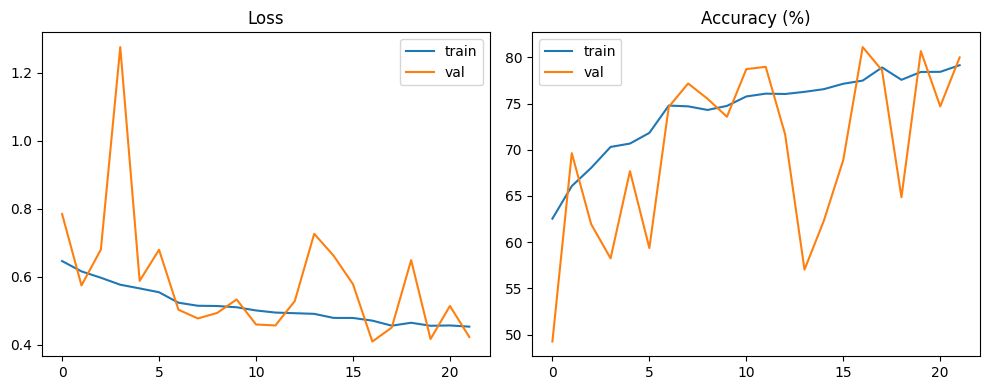

In [12]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(hist["tr_loss"], label="train")
plt.plot(hist["val_loss"], label="val")
plt.title("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(np.array(hist["tr_acc"]) * 100, label="train")
plt.plot(np.array(hist["val_acc"]) * 100, label="val")
plt.title("Accuracy (%)")
plt.legend()
plt.tight_layout()
plt.show()

Test accuracy: 74.88%
Confusion matrix:
 [[4458 1584]
 [ 211  892]]
              precision    recall  f1-score   support

      others     0.9548    0.7378    0.8324      6042
   questions     0.3603    0.8087    0.4985      1103

    accuracy                         0.7488      7145
   macro avg     0.6575    0.7733    0.6654      7145
weighted avg     0.8630    0.7488    0.7809      7145



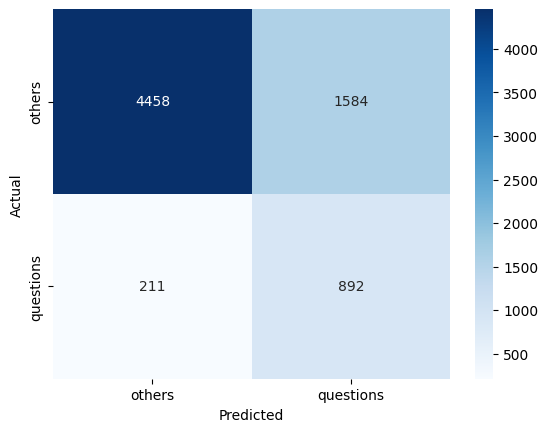

In [13]:
model.eval()
preds, gts = [], []
with torch.no_grad():
    for x, y in test_loader:
        p = (torch.sigmoid(model(x.to(device))) >= 0.5).long().cpu().squeeze()
        preds += p.tolist()
        gts += y.tolist()

preds, gts = np.array(preds), np.array(gts)
acc = (preds == gts).mean() * 100
print(f"Test accuracy: {acc:.2f}%")

cm = confusion_matrix(gts, preds)
print("Confusion matrix:\n", cm)
print(classification_report(gts, preds, target_names=class_names, digits=4))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()